Epoch [10/100], Train Loss: 0.0344, Test Loss: 0.0218
Epoch [20/100], Train Loss: 0.0182, Test Loss: 0.0201
Epoch [30/100], Train Loss: 0.0127, Test Loss: 0.0125
Epoch [40/100], Train Loss: 0.0114, Test Loss: 0.0130
Epoch [50/100], Train Loss: 0.0106, Test Loss: 0.0115
Epoch [60/100], Train Loss: 0.0102, Test Loss: 0.0112
Epoch [70/100], Train Loss: 0.0098, Test Loss: 0.0109
Epoch [80/100], Train Loss: 0.0096, Test Loss: 0.0107
Epoch [90/100], Train Loss: 0.0094, Test Loss: 0.0105
Epoch [100/100], Train Loss: 0.0093, Test Loss: 0.0104


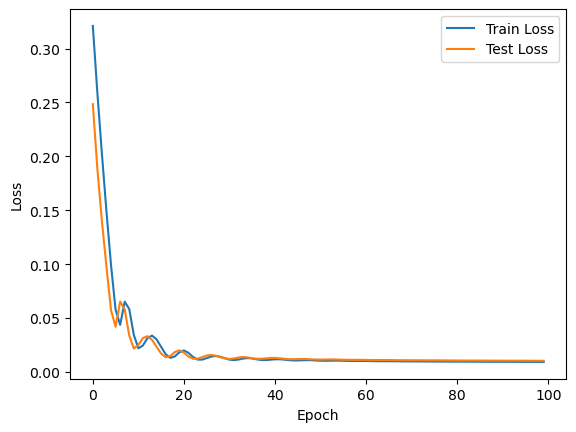

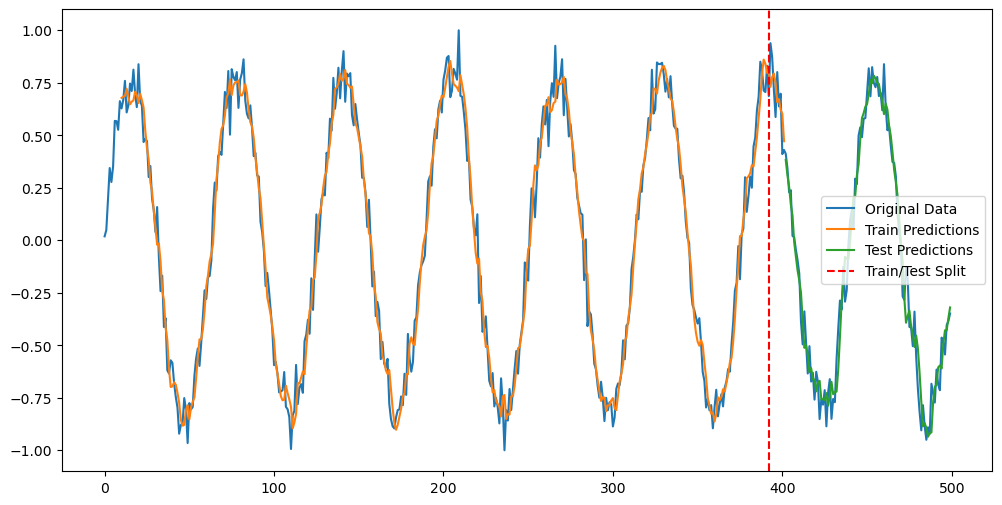

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(42)
np.random.seed(42)

time_steps = np.linspace(0, 50, 500)
data = np.sin(time_steps) + np.random.normal(0, 0.1, size=len(time_steps))

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 10
X, y = create_sequences(data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = torch.FloatTensor(X_train).unsqueeze(2)  
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).unsqueeze(2)
y_test = torch.FloatTensor(y_test)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        out, _ = self.rnn(x, h0)
        
        out = out[:, -1, :]
        
        out = self.fc(out)
        return out

input_size = 1
hidden_size = 32
output_size = 1
learning_rate = 0.01
num_epochs = 100

model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs.squeeze(), y_test)
        test_losses.append(test_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    train_predictions = model(X_train).squeeze().numpy()
    test_predictions = model(X_test).squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.plot(np.arange(seq_length, seq_length + len(train_predictions)), train_predictions, label='Train Predictions')
plt.plot(np.arange(seq_length + len(train_predictions), seq_length + len(train_predictions) + len(test_predictions)), 
         test_predictions, label='Test Predictions')
plt.axvline(x=split, color='r', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()